## Logistic Regression For Costa Rican Poverty Prediction

### Outline
**1. Project Setup** \
*1.1 Load Data and Packages* \
*1.2 Data Cleaning* \
*1.3 Oversampling* \
\
**2. What is a logistic regression?** \
*2.1 Summary of Approach* \
\
**3. Models** \
*3.1 Basic Models* \
*3.2 Improving Model Performance* \
\
**4. Findings, Limitations and Next Steps**

## 1. Project Setup

**1.1 Load Data**

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, classification_report
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#current_dir = os.getcwd()
#print(os.getcwd())
#parent_dir = os.path.dirname(current_dir)
#os.chdir(parent_dir)
import load_data as ld
import loops
df, train_indices, valid_indices= ld.load_train_data()
from evaluate_classification import evaluate_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import analyze_k


**1.2 Data Cleaning**

In [7]:
df, train_indices, valid_indices= ld.load_train_data()
print(train_indices)

{0: array([   1,    2,    3, ..., 2968, 2970, 2972]), 1: array([   0,    1,    3, ..., 2970, 2971, 2972]), 2: array([   0,    1,    2, ..., 2969, 2971, 2972]), 3: array([   0,    1,    2, ..., 2969, 2970, 2971]), 4: array([   0,    2,    4, ..., 2970, 2971, 2972])}


**1.3 Create oversampling:**\
We are looking to better predict Costa Rican Poverty in the following categories: 
- 1 = extreme poverty
- 2 = moderate poverty
- 3 = vulnerable households
- 4 = non vulnerable households

However, as demonstrated in our exploratory analysis, the majority of the data (66%) comes from class 4. Thus, a strong training model is most likely to predict the majority class rather than give accurate weights and biases as to reflect the different categories. 

As such we attempt to do over sampling- with random oversampling, SMOTE and ADASYM. We try random sampling with replacement as well as SVM SMOTE (Support Vector Machine Synthetic Minority Over-sampling Technique), which creates synthetic samples by randomly sampling the characteristics from occurrences in the minority class. The SVM class is designed for small and complex datasets. For SVM SMOTE, a neighborhood is defined using the parameter m_neighbors to decide if a sample is in danger, safe, or noise.

This gives us a number of different datasets to work with, so we can see how oversampling can impact our models.


In [10]:
X = df.drop(columns="Target")
y = df.loc[:, 'Target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)
train = pd.concat([X_train, y_train], axis=1)
train_df_resampled, train_y_resampled = ld.gen_oversample_data(train, seed = 12)

print("original y train", sorted(Counter(y_train).items()))
print( "Random Sampling", sorted(Counter(train_y_resampled).items()))

X_smote, y_smote = ld.gen_SMOTE_data(train, seed = 12)
print("SMOTE", sorted(Counter(train_y_resampled).items()))


               v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  r4h1  \
7633  194996.011248       0      4       0     1       1     1    1.0     2   
6150   90000.000000       0      4       0     1       1     0    0.0     0   
1577  206500.090627       0      6       0     1       1     0    0.0     0   
6580   47797.716994       1      3       0     1       1     0    0.0     1   
5901  206500.090627       0      6       0     1       0     0    0.0     0   
...             ...     ...    ...     ...   ...     ...   ...    ...   ...   
5250  166671.966131       0      4       0     1       1     0    0.0     1   
3437  291409.896671       0      7       0     1       1     1    1.0     0   
3576  134114.136450       0      4       0     1       1     0    0.0     0   
4127  128340.784706       0      5       0     1       1     0    0.0     0   
2683  281312.430705       0      5       0     1       1     1    1.0     0   

      r4h2  ...  agesq  max_education_level  hh_has

## 2. What is Logistic Regression? 

Logistic Regression is a type of supervised learning algorithm used for classification problems which uses a logistic function to model the probability of a binary or categorical outcome. In our case, our 1-4 levels of poverty produce categorical variables. 

The goal of logistic regression is to find the best parameters of a logistic function that minimizes the difference between the predicted probabilities and the actual outcomes. The logistic function uses the sigmoid function, which maps any real number into a range between 0 and 1, allowing us to interpret the output as a probability. The input features are weighted and combined linearly, and the resulting value is passed through the logistic function to produce a probability. We then use gradient descent to determine what the best classification is for these categories. 

One drawback however, is that it assumes linear relationships which based on the diversity of our data, may not be true in this case. 


### 2.1 What is Regularization
Regularization helps to improve the generalization performance of the model by balancing the bias-variance trade-off and reducing overfitting.  By penalizing the weights of the input features, regularization encourages the model to focus on the most important features that are most relevant to the target variable. Overfitting occurs when a model learns to fit the training data too closely, including noise and irrelevant features, leading to poor generalization performance on new, unseen data. In this case we will try L2 regularization which adds a penalty term proportional to the square of the weights.

## 3. Models
*3.1 Basic Models*


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.66
Weighted F1 Score: 0.55
Macro F1 Score: 0.25
Precision: Class 1: 1.0 Class 2: 0.42  Class 3: 0.2
           Class 4: 0.67
Recall: Class 1: 0.0 Class 2: 0.12  Class 3: 0.01
        Class 4: 0.99


Random Sampling


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.48
Weighted F1 Score: 0.53
Macro F1 Score: 0.37
Precision: Class 1: 0.18 Class 2: 0.24  Class 3: 0.2
           Class 4: 0.9
Recall: Class 1: 0.53 Class 2: 0.26  Class 3: 0.36
        Class 4: 0.54


SVM SMOTE


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.56
Weighted F1 Score: 0.57
Macro F1 Score: 0.34
Precision: Class 1: 0.22 Class 2: 0.24  Class 3: 0.24
           Class 4: 0.86
Recall: Class 1: 0.05 Class 2: 0.62  Class 3: 0.12
        Class 4: 0.69




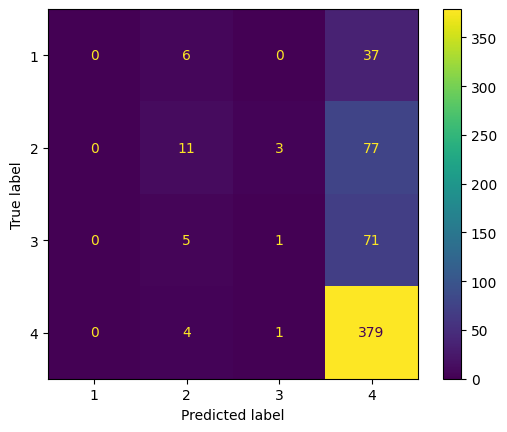

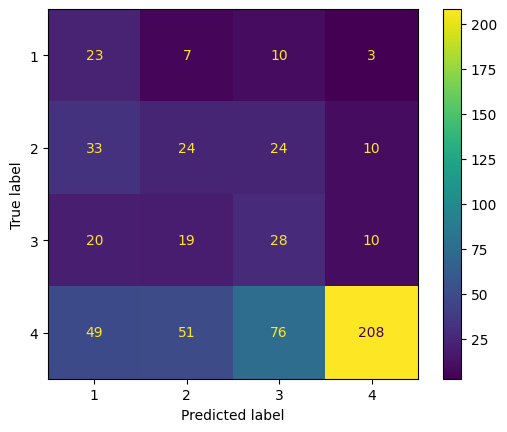

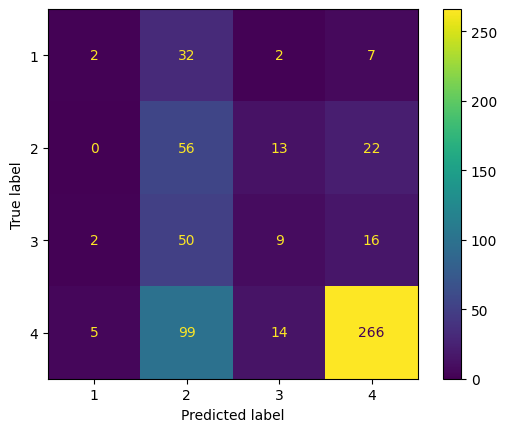

In [11]:
logreg = LogisticRegression(random_state=42)

# fit the model with data

reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(X_train, y_train)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("Random Sampling")
reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(train_df_resampled, train_y_resampled)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("SVM SMOTE")
reg = LogisticRegression(solver='lbfgs', penalty=None, max_iter=1000).fit(X_smote, y_smote)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)


*2.1 With Regularization*

As demonstrated below, regularization is crucial to the success of these models. It also allows us to use a better solver for smaller datasets: liblinear. It also has a substantially higher F1 score. However, the randomly selected do a better job of classifying the data into the correct catergory. 

Accuracy: 0.65
Weighted F1 Score: 0.54
Macro F1 Score: 0.24
Precision: Class 1: 0.0 Class 2: 0.39  Class 3: 1.0
           Class 4: 0.66
Recall: Class 1: 0.0 Class 2: 0.1  Class 3: 0.0
        Class 4: 0.99


Random Sampling
Accuracy: 0.55
Weighted F1 Score: 0.59
Macro F1 Score: 0.4
Precision: Class 1: 0.2 Class 2: 0.26  Class 3: 0.25
           Class 4: 0.89
Recall: Class 1: 0.51 Class 2: 0.26  Class 3: 0.38
        Class 4: 0.66


SVM SMOTE
Accuracy: 0.59
Weighted F1 Score: 0.59
Macro F1 Score: 0.35
Precision: Class 1: 0.38 Class 2: 0.25  Class 3: 0.22
           Class 4: 0.83
Recall: Class 1: 0.07 Class 2: 0.55  Class 3: 0.1
        Class 4: 0.76




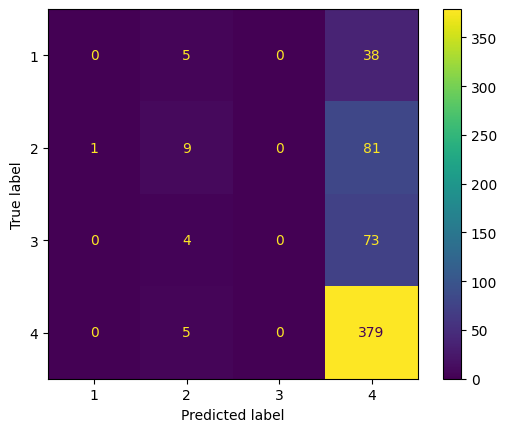

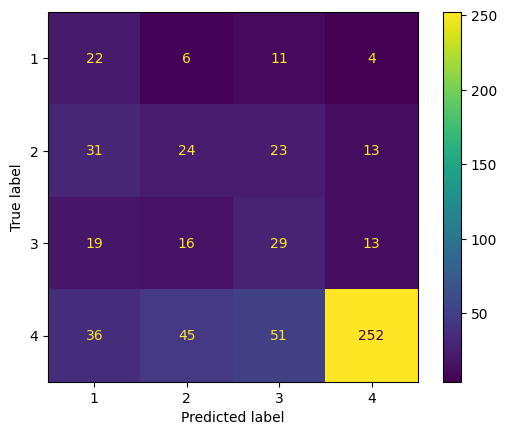

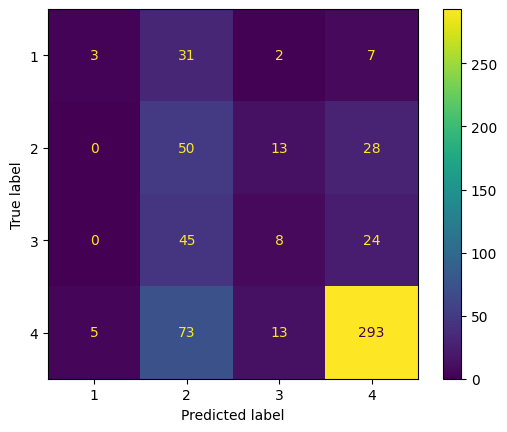

In [12]:
logreg = LogisticRegression(random_state=42)

# fit the model with data

reg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("Random Sampling")
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(train_df_resampled, train_y_resampled)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

print("SVM SMOTE")
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(X_smote, y_smote)
y_pred = reg.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)


*3.2 Improve Model Performance*

Adding Feature selection to these models as shown below does not seem to increase accuracy in a meaningful way - Particularly in characterization of 1's and two's. 

In [ ]:
def Run_models():
    print("Random forest")
    reg = RandomForestClassifier()
    reg.fit(X_smote, y_smote)
    y_pred = reg.predict(X_valid)
    evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

    print("Random forest -RFE")
    reg = RandomForestClassifier()
    reg.fit(train_df_resampled, train_y_resampled)
    y_pred = reg.predict(X_valid)
    evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


    print("With Smote- RFE")
    #Recursive feature elimination
    rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 6, step = 1)
    rfe.fit(X_smote, y_smote)
    y_pred = reg.predict(X_valid)
    evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

    print("Features selected:With Smote- RFE")
    print(X_train.iloc[:,[64,138,126,127,107,108,6]].columns)

    print("With Random Selection- RFE")
    #Recursive feature elimination
    rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 6, step = 1)
    rfe.fit(train_df_resampled, train_y_resampled)
    y_pred = reg.predict(X_valid)
    evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)
    print("Features selected:With Random Selection- RFE")
    print(X_train.iloc[:,[36,37,42,45,107,108]].columns)


    print("With Smote- Variance Threshold")
    # get rid of features without a lot of variance 
    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    a= X_smote.copy()
    rev_x = sel.fit_transform(a)
    reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)

    y_pred = reg.predict(sel.transform(X_valid.copy()))
    evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

    print("With Random Selection-Variance threshold")

    # get rid of features without a lot of variance 
    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    rev_x = sel.fit_transform(train_df_resampled.copy())
    reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, train_y_resampled)
    a= X_valid.copy()
    y_pred = reg.predict(sel.transform(a))
    evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)
Run_models()

In [ ]:
reg = LogisticRegression(solver='liblinear', penalty='l2')

bagging_classifier_rf = BaggingClassifier(
    base_estimator=reg,
    n_estimators=10,
    random_state=42)

bagging_classifier_rf.fit(X_smote, y_smote)
bc_rf_predictions = bagging_classifier_rf.predict(X_valid)


Accuracy: 0.66
Weighted F1 Score: 0.6
Macro F1 Score: 0.35
Precision: Class 1: 0.41 Class 2: 0.35  Class 3: 0.18
           Class 4: 0.72
Recall: Class 1: 0.16 Class 2: 0.22  Class 3: 0.04
        Class 4: 0.93


Accuracy: 0.67
Weighted F1 Score: 0.59
Macro F1 Score: 0.33
Precision: Class 1: 0.38 Class 2: 0.39  Class 3: 0.0
           Class 4: 0.72
Recall: Class 1: 0.18 Class 2: 0.19  Class 3: 0.0
        Class 4: 0.96


Accuracy: 0.66
Weighted F1 Score: 0.6
Macro F1 Score: 0.34
Precision: Class 1: 0.38 Class 2: 0.33  Class 3: 0.19
           Class 4: 0.73
Recall: Class 1: 0.13 Class 2: 0.2  Class 3: 0.06
        Class 4: 0.94


Accuracy: 0.67
Weighted F1 Score: 0.61
Macro F1 Score: 0.36
Precision: Class 1: 0.35 Class 2: 0.28  Class 3: 0.41
           Class 4: 0.73
Recall: Class 1: 0.14 Class 2: 0.14  Class 3: 0.15
        Class 4: 0.94


Accuracy: 0.68
Weighted F1 Score: 0.62
Macro F1 Score: 0.38
Precision: Class 1: 0.38 Class 2: 0.48  Class 3: 0.25
           Class 4: 0.73
Recall: Cl

{'accuracy': 0.6696981014628073,
 'f1': 0.6053878139845649,
 'Macro f1': 0.3504686806865081,
 'recall_1': 0.1713131313131313,
 'precision_1': 0.3799937216265817,
 'recall_2': 0.20120020429009192,
 'precision_2': 0.3643688387251795,
 'recall_3': 0.059154929577464786,
 'precision_3': 0.2048708372237784,
 'recall_4': 0.9431962751655847,
 'precision_4': 0.7247873883195902}

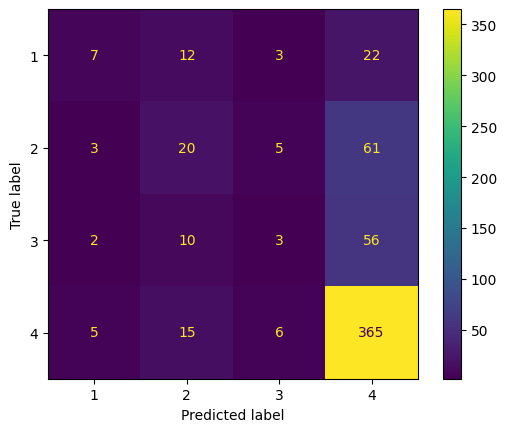

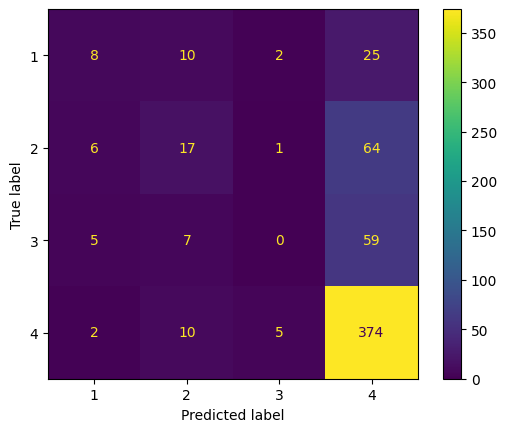

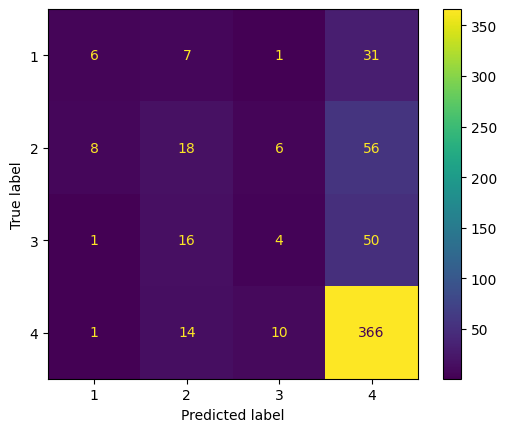

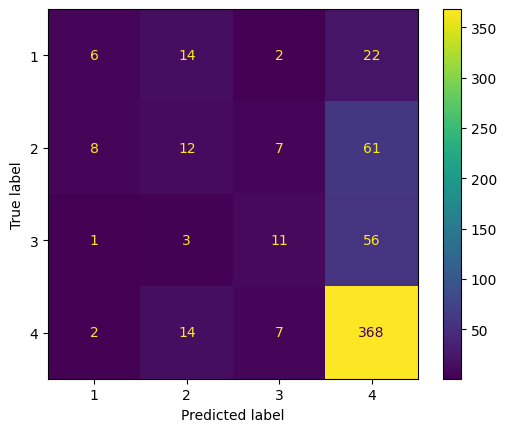

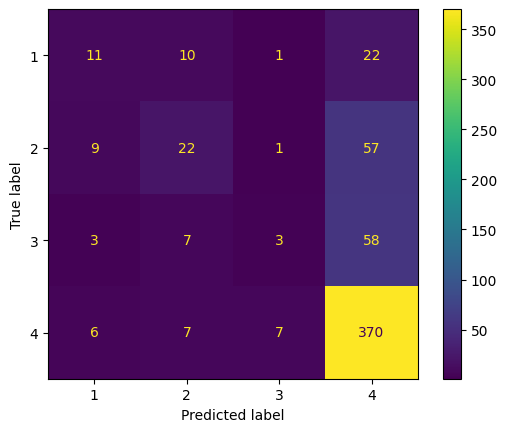

In [14]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
rev_x = sel.fit_transform(X_smote.copy())
reg = RandomForestClassifier(random_state = 12,
                        n_estimators = 1600,
                        min_samples_split = 2,
                        min_samples_leaf = 1,
                        max_features = 'sqrt',
                        max_depth = 100,
                        bootstrap = False).fit(rev_x, y_smote)
a= X_valid.copy()
#y_pred = reg.predict(sel.transform(a))
results= loops.loop_model(reg,df,train_indices,valid_indices,oversample=ld.gen_oversample_data, var_thresh=True)

#bagging_classifier_rf.fit(rev_x, y_smote)
#bc_rf_predictions = bagging_classifier_rf.predict(sel.transform(X_valid.copy()))
#evaluate_classification(bc_rf_predictions, y_valid, l=[1,2,3,4], cm=True, return_vals=False)

avg = analyze_k.average_outcome(results)
avg

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.51
Weighted F1 Score: 0.56
Macro F1 Score: 0.38
Precision: Class 1: 0.19 Class 2: 0.24  Class 3: 0.22
           Class 4: 0.89
Recall: Class 1: 0.48 Class 2: 0.33  Class 3: 0.32
        Class 4: 0.59




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.53
Weighted F1 Score: 0.58
Macro F1 Score: 0.37
Precision: Class 1: 0.18 Class 2: 0.25  Class 3: 0.19
           Class 4: 0.9
Recall: Class 1: 0.47 Class 2: 0.3  Class 3: 0.25
        Class 4: 0.64




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.54
Weighted F1 Score: 0.58
Macro F1 Score: 0.37
Precision: Class 1: 0.18 Class 2: 0.23  Class 3: 0.19
           Class 4: 0.87
Recall: Class 1: 0.33 Class 2: 0.34  Class 3: 0.24
        Class 4: 0.66




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.54
Weighted F1 Score: 0.58
Macro F1 Score: 0.38
Precision: Class 1: 0.22 Class 2: 0.2  Class 3: 0.22
           Class 4: 0.87
Recall: Class 1: 0.41 Class 2: 0.24  Class 3: 0.34
        Class 4: 0.66




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.54
Weighted F1 Score: 0.57
Macro F1 Score: 0.38
Precision: Class 1: 0.21 Class 2: 0.22  Class 3: 0.22
           Class 4: 0.84
Recall: Class 1: 0.48 Class 2: 0.29  Class 3: 0.21
        Class 4: 0.66




{'accuracy': 0.5317924341453752,
 'f1': 0.5730433184778848,
 'Macro f1': 0.37560457823445326,
 'recall_1': 0.4327272727272728,
 'precision_1': 0.1970125185721516,
 'recall_2': 0.29859550561797754,
 'precision_2': 0.22899180018232118,
 'recall_3': 0.2732394366197183,
 'precision_3': 0.20662639550646392,
 'recall_4': 0.6427949373729425,
 'precision_4': 0.8742888542486627}

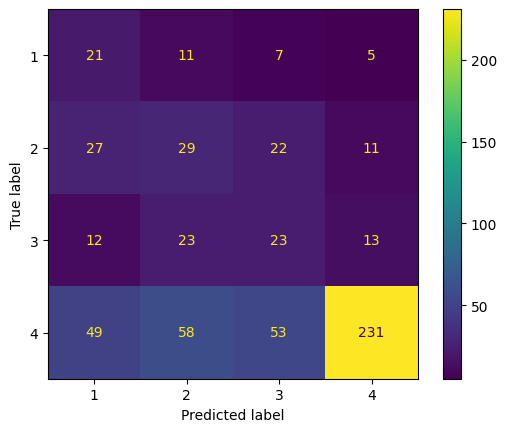

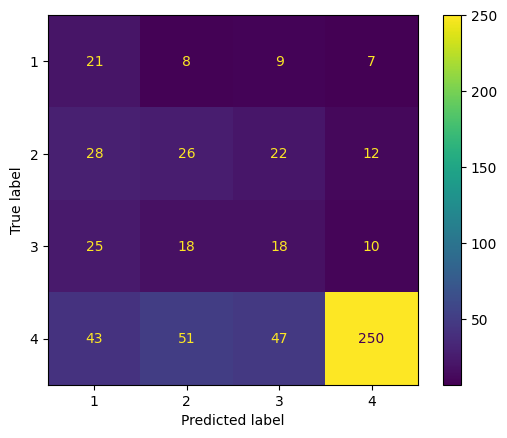

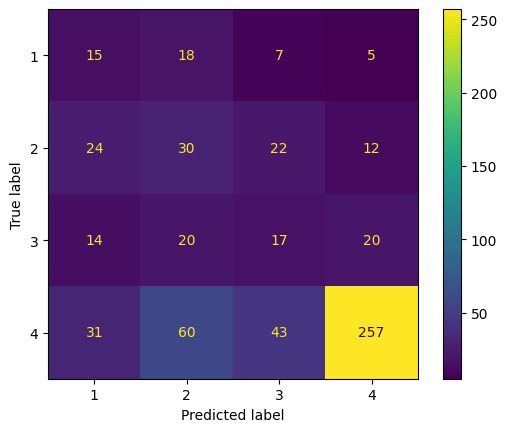

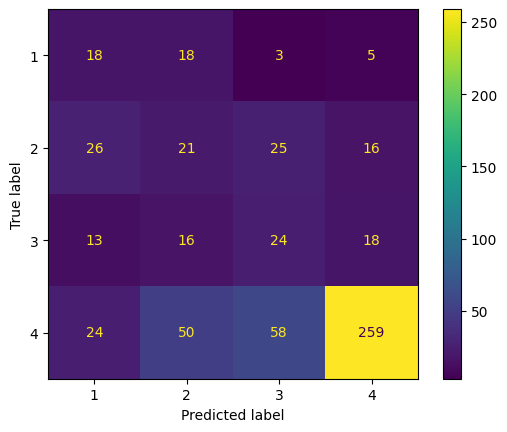

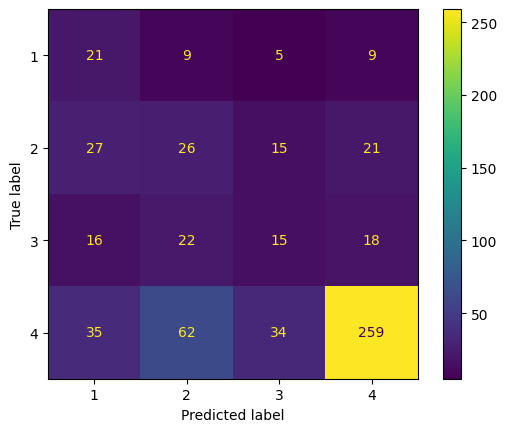

In [13]:

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
a= X_smote.copy()
rev_x = sel.fit_transform(a)
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)

bagging_classifier_rf = BaggingClassifier(
    base_estimator=reg,
    n_estimators=10,
    random_state=42)

results= loops.loop_model(bagging_classifier_rf,df,train_indices,valid_indices,oversample=ld.gen_oversample_data, var_thresh=True)

#bagging_classifier_rf.fit(rev_x, y_smote)
#bc_rf_predictions = bagging_classifier_rf.predict(sel.transform(X_valid.copy()))
#evaluate_classification(bc_rf_predictions, y_valid, l=[1,2,3,4], cm=True, return_vals=False)

avg = analyze_k.average_outcome(results)
avg


**4. Findings, Limitations and Next Steps**

Our models regardless of oversampling are fairly accurate at predicting 4, but need more data to provide any meaningful accuracy using logistic regression to predict the lower categories at any meaningful amount of accuracy. While, if we reference the logistic regression function, without overweighting we only classify the majority class 4. With overweighting and feature selection methods, we get our best predictors using regularized logistic regression in terms of classification accuracy and F1 score. But given the diversity of the results, and column selection in model development, it is clear feature selection as opposed to logistic regression usage is the most important part of this work. It is unclear if regularized logistic regression will be the best indicator going forward.



In [ ]:
def two_step(model, df, train_indices, valid_indices, oversample=None, var_thresh=False):
    print("Classification for 4")
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    a= X_smote.copy()
    rev_x = sel.fit_transform(a)
    reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)

    y_pred = reg.predict(sel.transform(X_valid.copy()))
    evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

    
    not_pred= df.loc[df.loc[:,'Target'].isin([1,2,3]),:]
    train_indices_not, valid_indices_not = ld.implement_kfold(not_pred, n_splits=5, shuffle=True, random_state=SEED)
    print("Classification for 1,2,3")
    loops.loop_model(model,not_pred,train_indices_not, valid_indices_not ,oversample=oversample ,var_thresh=var_thresh)


Accuracy: 0.59
Weighted F1 Score: 0.6
Macro F1 Score: 0.36
Precision: Class 1: 0.31 Class 2: 0.26  Class 3: 0.21
           Class 4: 0.83
Recall: Class 1: 0.09 Class 2: 0.54  Class 3: 0.1
        Class 4: 0.76


Accuracy: 0.68
Weighted F1 Score: 0.63
Macro F1 Score: 0.42
Precision: Class 1: 0.58 Class 2: 0.39  Class 3: 0.3
           Class 4: 0.75
Recall: Class 1: 0.26 Class 2: 0.33  Class 3: 0.09
        Class 4: 0.93




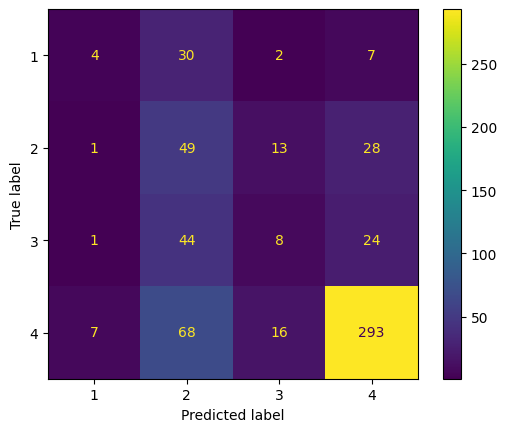

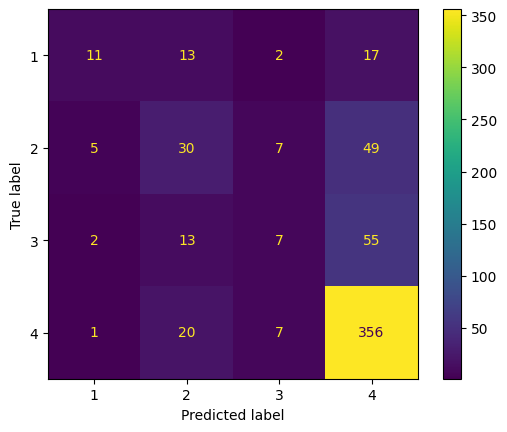

In [18]:
def Two_stage(model):
    reg=model.fit(X_smote, y_smote)
    y_pred = reg.predict(X_valid)
    #evaluate_classification(y_pred, y_true = y_valid, l=[1,2,3,4], cm = True)

    y_pred= pd.DataFrame(y_pred, columns=["pred"])
    a= pd.concat([X_valid.reset_index(drop=True), y_pred], axis=1)
    new_test_set= a.loc[a.loc[:,"pred"]!= 4,:]

    rev_dataset=pd.concat([X_smote, y_smote], axis=1)
    rev_dataset= rev_dataset.loc[rev_dataset.loc[:,"Target"]!= 4, :]
    Y= rev_dataset.loc[:,"Target"]
    X= rev_dataset.drop(columns="Target")
    reg= model.fit(X, Y)
    new_pred = reg.predict(new_test_set.drop(columns="pred"))
    a.loc[a.loc[:,"pred"]!= 4,"pred"]=new_pred
    evaluate_classification(a.loc[:,"pred"], y_true = y_valid, l=[1,2,3,4], cm = True)


Two_stage(LogisticRegression(solver='liblinear', penalty='l2'))
Two_stage(RandomForestClassifier(random_state = 12,
                        n_estimators = 1600,
                        min_samples_split = 2,
                        min_samples_leaf = 1,
                        max_features = 'sqrt',
                        max_depth = 100,
                        bootstrap = False))
